In [1]:
# TODO, maybe draw and analyse anchor positive assignemtn among different pyrimid level
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D, set_bev_background
from util_kitti import AVG_HEIGT, AVG_WIDTH, AVG_LENTH, init_zy_plt, init_xz_plt, load_tf_image_fpn
from util_kitti import ANCHOR_Y_3D_MEAN, ANCHOR_Y_3D_STD, init_img_plt, load_tf_image, type_dict, shape_dict
from util_kitti import draw_corner_2D, draw_birdeyes, calc_iou, draw_2Dbox, KITTI_Object, gac_original_anchor_parser
from anchor_assignment_method import maxIoU

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2

import glob
from collections import defaultdict, namedtuple

LABEL_DIR = "/home/lab530/KenYu/kitti/training/label_2/"
CALIB_DIR = "/home/lab530/KenYu/kitti/training/calib/"
ANCHOR_GENERATION_METHOD = "anchor_gac_fpn" # 'anchor_gac_fpn' 'anchor_my_gac_fpn_2d' 'anchor_my_gac_fpn_2d_share_weight'
SHOW_IMAGE = ['000169', '000173', '000185', '000296', '000008'] # '000369'

KITTI_2D_Object = namedtuple('KITTI_2D_Object', 'xmin, ymin, xmax, ymax')

if ANCHOR_GENERATION_METHOD == "anchor_gac_fpn":
    # Load dense anchor
    with open("/home/lab530/KenYu/visualDet3D/retinanet_2d_anchor.pkl", "rb") as f:
        anchors_tensor = pickle.load(f)
        anchors_tensor = anchors_tensor[0, :, :].cpu()
    print(f"anchors_tensor = {anchors_tensor.shape}") # torch.Size([28800, 4])

    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        anchors.append( KITTI_2D_Object(xmin=a[0], ymin=a[1], xmax=a[2], ymax=a[3]) )

elif ANCHOR_GENERATION_METHOD == "anchor_my_gac_fpn_2d":
    # Load dense anchor
    with open("/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/anchors_gac_fpn_2D.pkl", "rb") as f:
        anchors_tensor = pickle.load(f)
    print(f"anchors_tensor = {anchors_tensor.shape}")
    
    # Declare an 2D anchor object 
    anchors = []
    for a in anchors_tensor:
        anchors.append( KITTI_2D_Object(xmin=a[0], ymin=a[1], xmax=a[2], ymax=a[3]) )

elif ANCHOR_GENERATION_METHOD == "anchor_my_gac_fpn_2d_share_weight":
    # Load dense anchor
    with open("/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/anchors_gac_fpn_share_weight_2D.pkl", "rb") as f:
        anchors_tensor = pickle.load(f)
    print(f"anchors_tensor = {anchors_tensor.shape}")

    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        anchors.append( KITTI_2D_Object(xmin=a[0], ymin=a[1], xmax=a[2], ymax=a[3]) )

# Load ALL labels
labels_all = []
label_dict = defaultdict(list) # {'000169': [1,3,6,8], ...}
c = 0
for fn in glob.glob(LABEL_DIR + "*.txt"):
    name = fn.split('/')[-1].split('.')[0]
    
    img_ori_h, img_ori_w, _ = shape_dict[ type_dict[name] ]
    
    # For Pytorch-RetinaNet
    # P2_label = kitti_calib_file_parser(CALIB_DIR + fn.split('/')[-1], new_shape_tf = (384, 1280))
    
    # For GAC
    P2_label = kitti_calib_file_parser(CALIB_DIR + fn.split('/')[-1], 
                                       new_shape_tf = (288, 1280), 
                                       crop_tf = 100)
    
    for label in kitti_label_file_parser(fn, tf_matrix = P2_label):
        # filter labal via gac_original's critiria
        if label.occluded >= 2 or label.z3d <= 3 or label.category != "Car":
            continue
        else:
            # Transformation label because of resizing
            # TODO for pytorch-retinanetfpn, 
            # label.xmin *= 1280/img_ori_w
            # label.ymin *= 384 /img_ori_h
            # label.xmax *= 1280/img_ori_w
            # label.ymax *= 384 /img_ori_h

            # TODO for anchor_gac_fpn, I think this label translation is not very accurate because crop-in, pad-out operation is not considered here 
            label.ymin -= 100
            label.ymax -= 100
            label.xmin *= 288 /(img_ori_h - 100)
            label.ymin *= 288 /(img_ori_h - 100)
            label.xmax *= 288 /(img_ori_h - 100)
            label.ymax *= 288 /(img_ori_h - 100)
            
            label_dict[label.idx_img].append(c)
            labels_all.append(label)
            c += 1

print(f"Number of total ground trues = {len(labels_all)}")
# print(f"Number of total label file = {len(label_dict)}") # 
print("=====================================")

# Load images
imgs_tf = []
for img_id in SHOW_IMAGE:
    img = load_tf_image(f"/home/lab530/KenYu/kitti/training/image_2/{img_id}.png")
    imgs_tf.append(img)

# # This for fpn
# imgs_tf = []
# for img_id in SHOW_IMAGE:
#     img = load_tf_image_fpn(f"/home/lab530/KenYu/kitti/training/image_2/{img_id}.png")
#     imgs_tf.append(img)
# print(anchors)


anchors_tensor = torch.Size([69210, 4])
Number of total ground trues = 21291


# Draw Anchor Assignment result 

Total number of Assignment = 505262
Total GroundTrue = 21291
Total covered groundtrue = 20384
Total missed groundtrue = 907
Average anchors for every groundtrue = 23.73124794514114
Cover rate = 95.73998403081114%


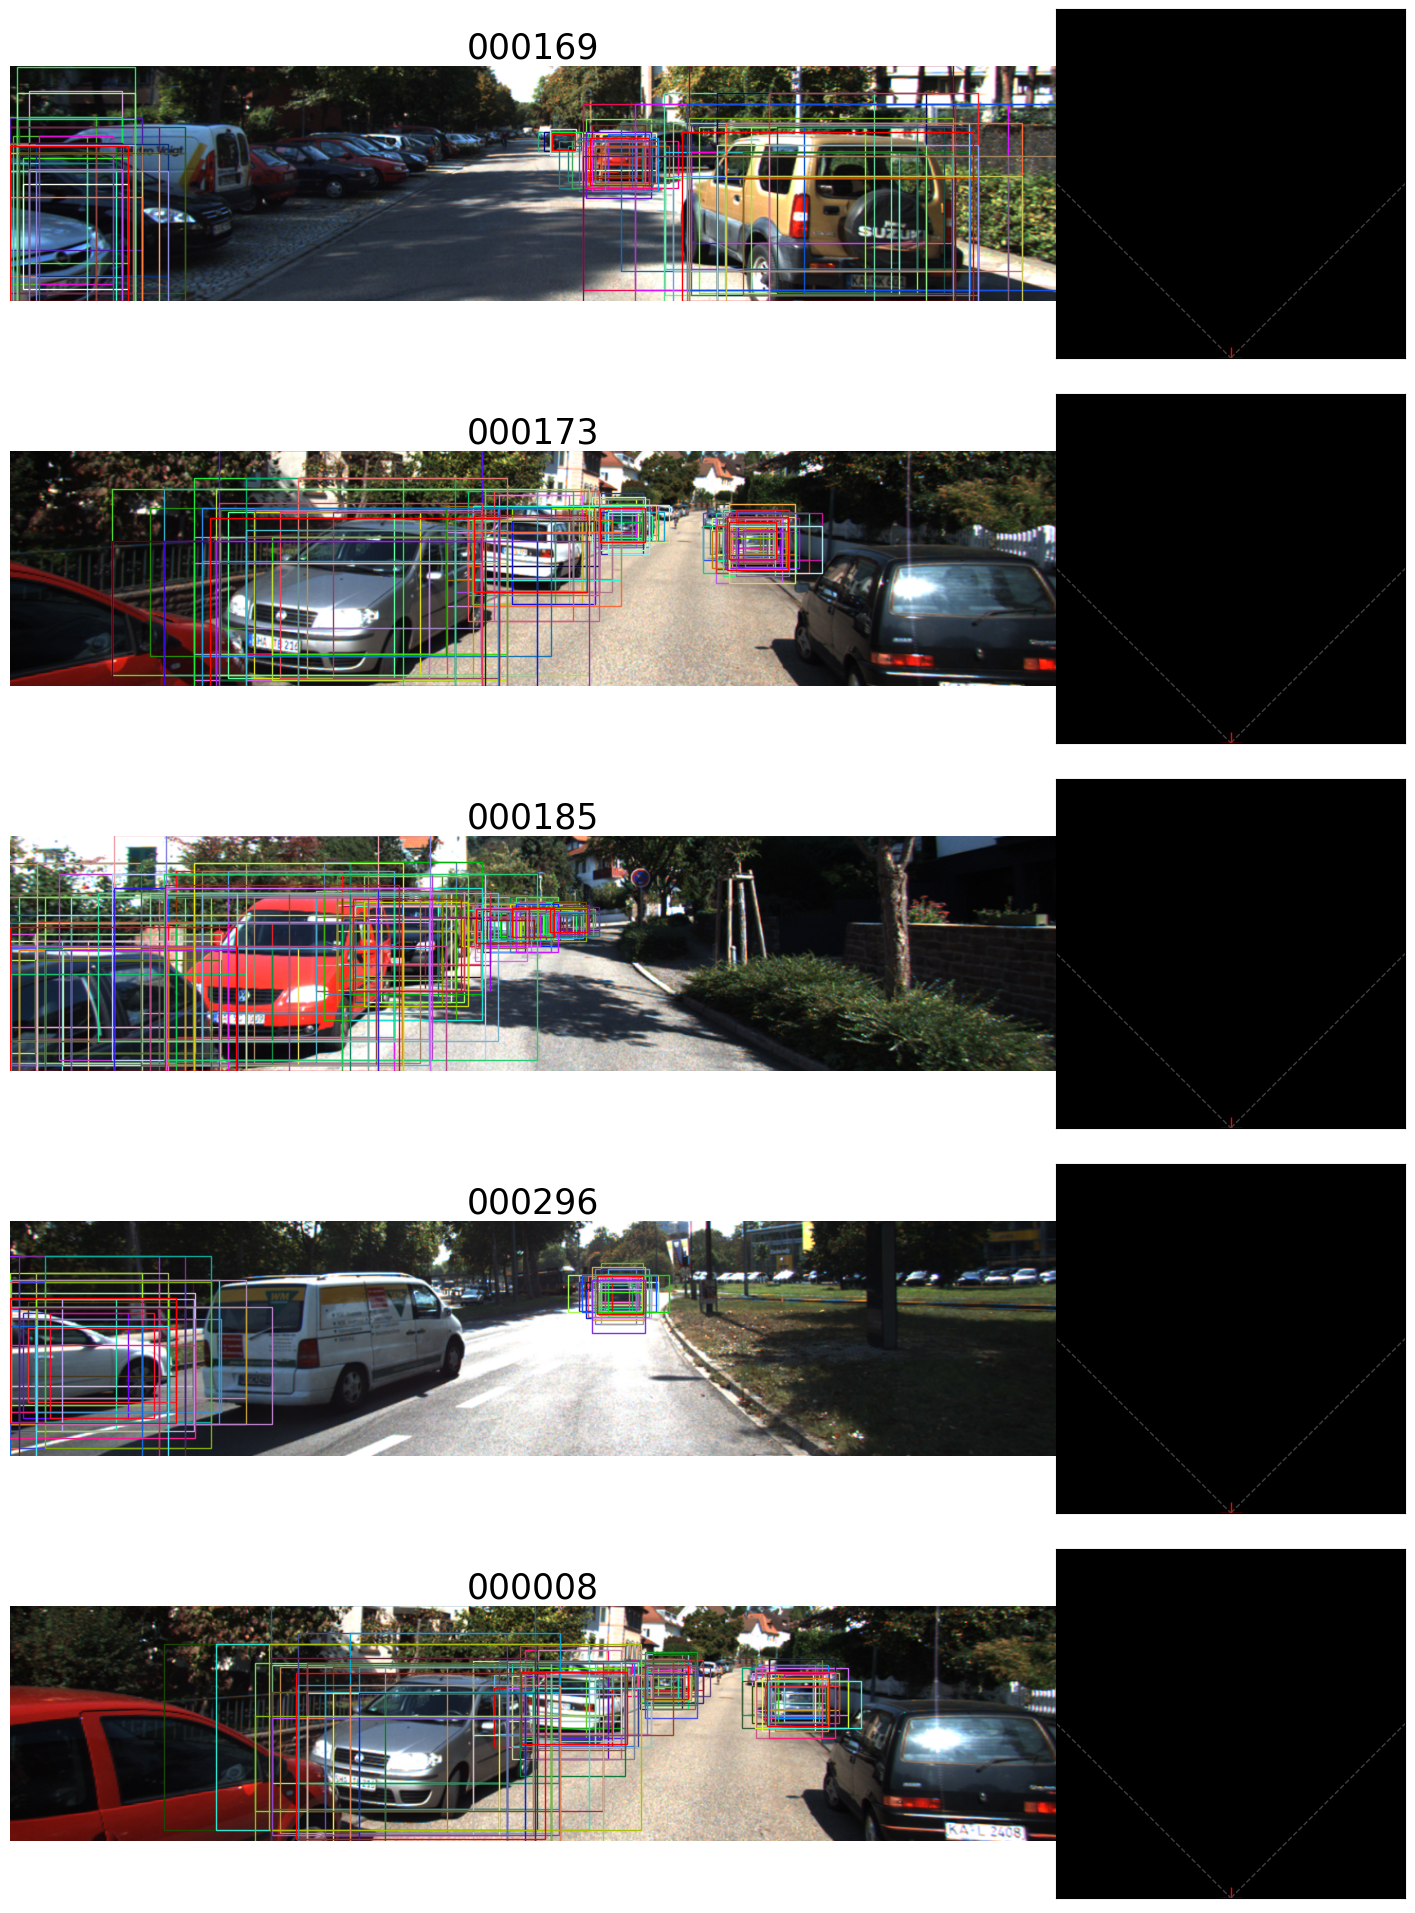

In [2]:
axs = init_img_plt(imgs_tf, SHOW_IMAGE)

assign_result = [[] for _ in range(len(labels_all))]

for idx_img in label_dict:
    # if idx_img != '000169': continue

    labels = [ labels_all[i] for i in label_dict[idx_img] ]

    # Get labels_tensor for maxIoU
    labels_tensor = []
    for label in labels:
        labels_tensor.append([label.xmin, label.ymin, label.xmax, label.ymax])
    labels_tensor = torch.FloatTensor(labels_tensor)
    
    # Calculate maxIoU
    pos_inds, neg_inds, anchor_assignment = maxIoU(anchors_tensor, labels_tensor)

    n_pos = pos_inds.shape[0]
    # n_neg = neg_inds.shape[0]
    # if idx_img == '000008':
    #     print(f"n_pos = {n_pos}")
    #     print(f"pos_inds = {pos_inds}")

    n_gt = len(labels)
    # 
    unique, counts = torch.unique(anchor_assignment, return_counts=True)
    anchor_assign = dict(zip(unique.cpu().numpy(), counts.cpu().numpy())) # {0.0: 9308, 1.0: 24}
    
    for i in range(n_gt):
        if i in anchor_assign:
            # TODO don't know why 
            assign_list = (anchor_assignment == i).nonzero(as_tuple=True)[0].numpy().tolist()
            assign_result[ label_dict[idx_img][i] ] = assign_list
            # print(f"assign_list in assignemnt = {assign_list}")

    if idx_img in SHOW_IMAGE:
        idx_show = SHOW_IMAGE.index(idx_img)
        
        # Draw Positive anchors
        for i in range(n_pos):
            color = (random.random(), random.random(), random.random())
            draw_2Dbox(axs[idx_show][0], (anchors[pos_inds[i]].xmin, anchors[pos_inds[i]].ymin, anchors[pos_inds[i]].xmax, anchors[pos_inds[i]].ymax), color = color)
            
        # Draw ground true 3d bbox
        for label in labels:
            draw_2Dbox(axs[idx_show][0], (label.xmin, label.ymin, label.xmax, label.ymax), color = (1,0,0))


# Get number of covered groundTrue
n_cover_gt = 0
for assign_list in assign_result:
    if len(assign_list) > 0:
        n_cover_gt += 1

# Get number of assignment
n_assign = 0
for assign_list in assign_result:
    n_assign += len(assign_list)

print(f"Total number of Assignment = {n_assign}")
print(f"Total GroundTrue = {len(labels_all)}")
print(f"Total covered groundtrue = {n_cover_gt}")
print(f"Total missed groundtrue = {len(labels_all) - n_cover_gt}")
print(f"Average anchors for every groundtrue = {n_assign / len(labels_all)}")
print(f"Cover rate = {100*n_cover_gt / len(labels_all)}%")
